In [14]:
import pandas as pd
import os

def load_dataset(folder_path):
    # Đọc 3 file trong folder
    try:
        with open(os.path.join(folder_path, 'sents.txt'), 'r', encoding='utf-8') as f:
            sents = f.read().splitlines()
        with open(os.path.join(folder_path, 'sentiments.txt'), 'r', encoding='utf-8') as f:
            sentiments = f.read().splitlines()
        with open(os.path.join(folder_path, 'topics.txt'), 'r', encoding='utf-8') as f:
            topics = f.read().splitlines()
            
        # Kiểm tra độ dài
        if len(sents) == len(sentiments) == len(topics):
            df = pd.DataFrame({
                'sentence': sents,
                'sentiment': sentiments,
                'topic': topics
            })
            # Chuyển nhãn sang số
            df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')
            df['topic'] = pd.to_numeric(df['topic'], errors='coerce')
            return df.dropna()
        else:
            print(f"❌ Lỗi: Số dòng trong {folder_path} không khớp!")
            return None
    except Exception as e:
        print(f"❌ Lỗi đọc folder {folder_path}: {e}")
        return None

# Load 3 tập riêng biệt
print("Đang đọc dữ liệu...")
df_train = load_dataset('/kaggle/input/dataset-nlp/train')  # Folder train
df_dev   = load_dataset('/kaggle/input/dataset-nlp/dev')    # Folder dev
df_test  = load_dataset('/kaggle/input/dataset-nlp/test')   # Folder test

print(f"Train: {len(df_train)} dòng")
print(f"Dev:   {len(df_dev)} dòng")
print(f"Test:  {len(df_test)} dòng")

Đang đọc dữ liệu...
Train: 11426 dòng
Dev:   1583 dòng
Test:  3166 dòng



==================== PHÂN TÍCH PHÂN BỐ DỮ LIỆU: SENTIMENT ====================
            Số lượng  Tỷ lệ (%)
Label_Name                     
Tích cực        5643      49.39
Tiêu cực        5325      46.60
Trung tính       458       4.01


/tmp/ipykernel_55/310215907.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label_Name', data=df_viz, order=counts.index, palette=palette)


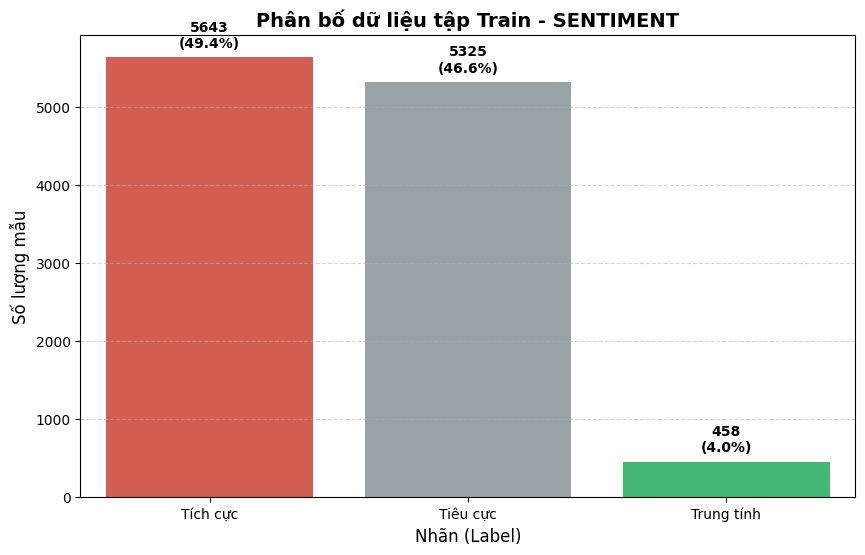

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_class_distribution(df, label_col, task_name):
    print(f"\n{'='*20} PHÂN TÍCH PHÂN BỐ DỮ LIỆU: {task_name.upper()} {'='*20}")
    label_map = {0: 'Tiêu cực', 1: 'Trung tính', 2: 'Tích cực'}
    palette = ['#e74c3c', '#95a5a6', '#2ecc71'] # Đỏ - Xám - Xanh
    
    # 2. Tạo DataFrame tạm để vẽ
    df_viz = df.copy()
    df_viz['Label_Name'] = df_viz[label_col].map(label_map)
    
    # 3. Tính toán số lượng và tỷ lệ
    counts = df_viz['Label_Name'].value_counts()
    percent = df_viz['Label_Name'].value_counts(normalize=True) * 100
    
    stats_df = pd.DataFrame({'Số lượng': counts, 'Tỷ lệ (%)': percent.round(2)})
    print(stats_df)
    
    # 4. Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='Label_Name', data=df_viz, order=counts.index, palette=palette)
    
    # Trang trí
    plt.title(f'Phân bố dữ liệu tập Train - {task_name.upper()}', fontsize=14, fontweight='bold')
    plt.xlabel('Nhãn (Label)', fontsize=12)
    plt.ylabel('Số lượng mẫu', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Thêm số liệu trên đầu cột
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}\n({(height/len(df)*100):.1f}%)',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')
    
    plt.show()

analyze_class_distribution(df_train, 'sentiment', 'sentiment')

In [16]:
!pip install langdetect

In [17]:
import pandas as pd
from langdetect import detect
from collections import Counter
import re

# 1. Khởi tạo 2 kho lưu trữ
eng_words_storage = []   # Chứa từ detect ra 'en'
other_words_storage = [] # Chứa từ detect ra 'lt', 'sv', 'et', 'unknown'...

# Danh sách an toàn (các từ VN ngắn dễ bị nhận nhầm)
safe_vi_words = {"sinh", "em", "hay", "vui","cho", "thi"}
vietnamese_special_chars = set("ăâđêôơưàảãáạằẳẵắặầẩẫấậèẻẽéẹềểễếệìỉĩíịòỏõóọồổỗốộờởỡớợùủũúụừửữứựỳỷỹýỵ")

def is_actually_vietnamese(word):
    # Nếu có dấu mũ/râu hoặc nằm trong danh sách từ ngắn thông dụng -> Là tiếng Việt
    if any(char in vietnamese_special_chars for char in word) or word in safe_vi_words:
        return True
    return False

def scan_and_split(text):
    # Xóa ký tự đặc biệt, chuyển về chữ thường
    words = re.findall(r'\w+', str(text).lower())
    
    for word in words:
        if len(word) < 2: continue # Bỏ qua ký tự đơn
        if word.isnumeric(): continue # Bỏ qua số thuần túy
        
        # BƯỚC 1: Lọc an toàn
        if is_actually_vietnamese(word):
            continue 

        # BƯỚC 2: Detect và phân loại
        try:
            lang = detect(word)
            
            if lang == 'vi':
                continue
            elif lang == 'en':
                eng_words_storage.append(word)
            else:
                other_words_storage.append(word)
        except:
            other_words_storage.append(word)

# 2. Chạy quét (Sử dụng cột đã sửa lỗi nếu có, hoặc cột gốc)
# df là DataFrame của bạn
print("Đang quét dữ liệu...")
df_train['sentence'].apply(scan_and_split) 

# 3. Hàm hỗ trợ ghi file txt đẹp
def save_to_txt(filename, title, data_list):
    counts = Counter(data_list).most_common()
    with open(filename, "w", encoding="utf-8") as f:
        f.write(f"{title}\n")
        f.write("="*50 + "\n")
        f.write(f"{'Từ vựng':<20} | {'Số lần xuất hiện':<20}\n")
        f.write("-"*50 + "\n")
        for word, count in counts:
            f.write(f"{word:<20} | {count:<20}\n")
    print(f"-> Đã lưu file: {filename} ({len(counts)} từ)")

# 4. Thực hiện lưu file
save_to_txt("nhom_tieng_anh.txt", "DANH SÁCH THUẬT NGỮ TIẾNG ANH (CODE-SWITCHING)", eng_words_storage)
save_to_txt("nhom_tu_la_khac.txt", "DANH SÁCH TỪ VIẾT TẮT / TEENCODE / RÁC", other_words_storage)

print("\nHoàn tất! Bạn hãy mở 2 file txt vừa tạo để kiểm tra.")

Đang quét dữ liệu...
-> Đã lưu file: nhom_tieng_anh.txt (47 từ)
-> Đã lưu file: nhom_tu_la_khac.txt (661 từ)

Hoàn tất! Bạn hãy mở 2 file txt vừa tạo để kiểm tra.


In [18]:
import pandas as pd
import re

# 1. TỪ ĐIỂN ÁNH XẠ (SMART MAPPING)
# Chiến lược: Chỉ sửa lỗi chính tả và teencode vô nghĩa. 
# Giữ nguyên các từ cảm thán và tiếng Anh để bảo toàn sắc thái.
mapping_dict = {
    # --- NHÓM 1: TEENCODE & VIẾT TẮT CƠ BẢN (BẮT BUỘC SỬA) ---
    "ko": "không", "k": "không", "kh": "không", "hok": "không", "hong": "không",
    "dc": "được", "dk": "được", "đc": "được",
    "ok": "tốt", "oki": "tốt", "oke": "tốt",
    "uh": "ừ", "uhm": "ừ", "um": "ừ",
    "r": "rồi", "roi": "rồi",
    "vs": "với", "z": "vậy", "j": "gì",
    "wa": "quá", "w": "quá",
    "t": "tôi", "mk": "mình",
    "gud": "tốt", "h": "giờ",
    "f": "phải",
    "dt": "điện thoại", "m": "mày",
    
    # --- NHÓM 2: SỬA LỖI CHÍNH TẢ TỪ CHUYÊN NGÀNH (BẮT BUỘC SỬA) ---
    "wed": "web", 
    "silde": "slide", "slile": "slide", "slides": "slide",
    "dealine": "deadline", "de2": "deadline",
    "lap": "laptop", 
    "pro": "chuyên nghiệp",
    "face": "facebook", "fb": "facebook",
    "turnitindotcom": "turnitin",
    "it002dotf23": "môn học",
    "it003dote21": "môn học",
    "it006dote12": "môn học",
    "coursedotuitdotedudotvn": "trang web môn học",
    "daadotuitdotedudotvn": "trang web môn học",
    
    # --- NHÓM 3 & 4: TẠM THỜI TẮT ĐỂ TRÁNH MẤT SẮC THÁI (QUAN TRỌNG) ---
    # PhoBERT hiểu được "good", "bad", "wtf" và các icon. 
    # Việc map cứng nhắc (vd: wtf -> tệ) sẽ làm mất mức độ nghiêm trọng của câu.
    
    # "good": "tốt", "very": "rất", "best": "tốt nhất",
    # "bad": "tệ", "fail": "trượt", "pass": "đậu",
    # "nice": "tốt", "like": "thích", "love": "yêu thích",
    # "wtf": "tệ", "nope": "không",
    
    # "colonsmile": "vui", # <-- Tắt cái này để giữ lại sự mỉa mai nếu có
    # "colonsad": "buồn",
    # "colonlove": "yêu thích",
    
    # --- NHÓM 5: TÊN RIÊNG ---
    "uit": "trường đại học công nghệ thông tin",
    "hcm": "hồ chí minh",
    "av1": "anh văn 1", "av2": "anh văn 2", "av3": "anh văn 3",
    "it": "công nghệ thông tin"
}

# 2. DANH SÁCH RÁC (GARBAGE)
garbage_set = {
    "doubledot", "dot", "fraction", "vdotv", "dotdotdot", 
    "coloncolon", "11doubledot55", "12doubledot00", "pl",
    "gt", "lt", "amp", "quot"
}

def clean_final_text(text):
    if not isinstance(text, str):
        return ""
        
    text = text.lower().strip()
    
    # 1. Xóa mã ẩn danh
    text = re.sub(r'wzjwz\d*', '', text)
    
    # 2. [CẬP NHẬT] Xử lý dấu câu thông minh hơn
    # Thay vì xóa hết, ta chèn khoảng trắng để tách từ nhưng giữ lại ký tự IT
    # Giữ lại: chữ cái, số, _, +, #, . (cho C++, C#, .net, node.js)
    # Các ký tự khác (phẩy, chấm than...) sẽ bị thay bằng khoảng trắng để tách từ
    text = re.sub(r'[^\w\s\+\#\.]', ' ', text)
    
    # Xóa dấu chấm (.) ở cuối câu hoặc đứng một mình để tránh nhiễu, 
    # nhưng giữ dấu chấm trong từ (vd: node.js)
    # text = re.sub(r'\s\.\s', ' ', text) 
    
    words = text.split()
    clean_words = []
    
    for word in words:
        if word in garbage_set:
            continue
            
        if word in mapping_dict:
            clean_words.append(mapping_dict[word])
        else:
            clean_words.append(word)
            
    return " ".join(clean_words)

# --- CHẠY THỬ NGHIỆM ---
test_sentences = [
    "thầy dạy C++ và C# rất good, nhưng silde hơi mờ...", 
    "deadline dí chạy ko kịp wzjwz123",
    "môn này wtf luôn colonlove", # Test xem nó có giữ lại wtf không
]

print("--- KIỂM TRA LOGIC LÀM SẠCH (BẢN TỐI ƯU) ---")
for s in test_sentences:
    print(f"Gốc: {s}")
    print(f"Sửa: {clean_final_text(s)}")
    print("-" * 30)

# --- ÁP DỤNG VÀO DATAFRAME ---
if 'df_train' in globals():
    input_col = 'sentence_corrected' if 'sentence_corrected' in df_train.columns else 'sentence'
    print(f"\nĐang xử lý dữ liệu thật từ cột '{input_col}'...")
    
    df_train['sentence_final'] = df_train[input_col].apply(clean_final_text)
    df_test['sentence_final'] = df_test[input_col].apply(clean_final_text)
    df_dev['sentence_final'] = df_dev[input_col].apply(clean_final_text)

    print("✅ Hoàn tất! Model sẽ học tốt hơn nhờ giữ lại đặc trưng cảm xúc.")

--- KIỂM TRA LOGIC LÀM SẠCH (BẢN TỐI ƯU) ---
Gốc: thầy dạy C++ và C# rất good, nhưng silde hơi mờ...
Sửa: thầy dạy c++ và c# rất good nhưng slide hơi mờ...
------------------------------
Gốc: deadline dí chạy ko kịp wzjwz123
Sửa: deadline dí chạy không kịp
------------------------------
Gốc: môn này wtf luôn colonlove
Sửa: môn này wtf luôn colonlove
------------------------------

Đang xử lý dữ liệu thật từ cột 'sentence'...
✅ Hoàn tất! Model sẽ học tốt hơn nhờ giữ lại đặc trưng cảm xúc.


In [19]:
pip install underthesea

Note: you may need to restart the kernel to use updated packages.


In [20]:
# 2. Code thay thế hoàn toàn cho VnCoreNLP
from underthesea import word_tokenize

def segment_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    # format='text' trả về dạng: "Đại_học Quốc_gia Hà_Nội"
    return word_tokenize(text, format="text")

# 3. Áp dụng vào DataFrame của bạn
print("Đang tách từ bằng Underthesea (An toàn, không lỗi Java)...")
df_train['sentence_segmented'] = df_train['sentence_final'].apply(segment_text)
df_test['sentence_segmented'] = df_test['sentence_final'].apply(segment_text)
df_dev['sentence_segmented'] = df_dev['sentence_final'].apply(segment_text)


# Kiểm tra kết quả
print(df_train[['sentence_final', 'sentence_segmented']].head())

Đang tách từ bằng Underthesea (An toàn, không lỗi Java)...
                                      sentence_final  \
0                          slide giáo trình đầy đủ .   
1       nhiệt tình giảng dạy gần gũi với sinh viên .   
2               đi học đầy đủ full điểm chuyên cần .   
3  chưa áp dụng công nghệ thông tin và các thiết ...   
4  thầy giảng bài hay có nhiều bài tập ví dụ ngay...   

                                  sentence_segmented  
0                          slide giáo_trình đầy_đủ .  
1       nhiệt_tình giảng_dạy gần_gũi với sinh_viên .  
2               đi học đầy_đủ full_điểm chuyên cần .  
3  chưa áp_dụng công_nghệ_thông_tin và các thiết_...  
4  thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...  


In [21]:
!pip install transformers datasets accelerate scikit-learn

In [22]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import shutil
import os
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# CẤU HÌNH
MODEL_NAME = "vinai/phobert-base-v2"
MAX_LEN = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang chạy trên thiết bị: {device}")

# 1. DATASET CLASS
class UITVSFCDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. HÀM TÍNH ĐIỂM (MACRO AVERAGE CHO IMBALANCED DATA)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = accuracy_score(labels, preds)
    # Dùng average='macro' để đánh giá công bằng giữa các lớp ít và nhiều
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

# 3. CUSTOM TRAINER ĐỂ NHẬN TRỌNG SỐ
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Chuyển weights sang Tensor và đưa vào thiết bị của Model
        # Lưu ý: float32 là bắt buộc cho CrossEntropyLoss
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Lấy nhãn và output
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Đảm bảo weights nằm đúng thiết bị với model (tránh lỗi device mismatch)
        if self.class_weights.device != logits.device:
             self.class_weights = self.class_weights.to(logits.device)

        # Hàm loss có trọng số
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# 4. HÀM TRAIN PIPELINE (ĐÃ TỐI ƯU HYPERPARAMETERS)
def train_pipeline_v4_weighted(task_name, df_train, df_dev, df_test, input_col, label_col, num_labels, epochs=5, batch_size=32):
    print(f"\n{'='*20} HUẤN LUYỆN CÓ TRỌNG SỐ: {task_name.upper()} {'='*20}")
    
    # --- TÍNH TOÁN TRỌNG SỐ ---
    y_train = df_train[label_col].values
    weights = compute_class_weight(
        class_weight="balanced", 
        classes=np.unique(y_train), 
        y=y_train
    )
    print(f"⚖️ Class Weights được áp dụng: {weights}")
    
    # Load Model & Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
    model.to(device)
    
    # Tạo Dataset (Đã map từ DF vào Dataset)
    train_dataset = UITVSFCDataset(df_train[input_col].values, df_train[label_col].values, tokenizer, MAX_LEN)
    eval_dataset  = UITVSFCDataset(df_dev[input_col].values,   df_dev[label_col].values,   tokenizer, MAX_LEN)
    test_dataset  = UITVSFCDataset(df_test[input_col].values,  df_test[label_col].values,  tokenizer, MAX_LEN)
    
    # Cấu hình Training (BEST PRACTICE CHO PHOBERT)
    training_args = TrainingArguments(
        output_dir=f'./results_{task_name}',
        
        # 1. Hyperparameters quan trọng
        learning_rate=2e-5,          # <--- Đã sửa: 2e-5 là tốt nhất cho PhoBERT
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        
        # 2. Tối ưu hóa quá trình học
        weight_decay=0.01,
        warmup_ratio=0.1,            # <--- Đã sửa: Dùng tỷ lệ an toàn hơn số bước cố định
        
        # 3. Đánh giá & Lưu trữ
        eval_strategy="epoch",        
        save_strategy="epoch",        
        save_total_limit=1,          # Chỉ giữ 1 model tốt nhất để tiết kiệm ổ cứng
        load_best_model_at_end=True, # Tự động load lại model ngon nhất
        metric_for_best_model="f1_macro", # Ưu tiên F1 Macro
        greater_is_better=True,
        
        # 4. Log
        logging_dir='./logs',
        logging_steps=50,            # In log thường xuyên hơn để theo dõi
        report_to="none"             # Tắt wandb
    )
    
    # Sử dụng Weighted Trainer
    trainer = WeightedTrainer(
        class_weights=weights,
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics 
    )
    
    # Train
    print(">>> Đang Training với Weighted Loss (Kiên nhẫn chờ nhé)...")
    trainer.train()
    
    # Lưu & Dọn dẹp
    print(">>> Đang lưu model tốt nhất...")
    save_path = f"./best_model_{task_name}"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    
    # Xóa thư mục checkpoint tạm để giải phóng dung lượng
    if os.path.exists(f'./results_{task_name}'):
        shutil.rmtree(f'./results_{task_name}')

    # Đánh giá Test
    print(f"\n>>> Đang chấm điểm trên tập TEST...")
    test_result = trainer.predict(test_dataset)
    
    acc = test_result.metrics['test_accuracy']
    f1  = test_result.metrics['test_f1_macro']
    prec = test_result.metrics['test_precision_macro']
    rec  = test_result.metrics['test_recall_macro']
    
    print("-" * 50)
    print(f"🏆 KẾT QUẢ CUỐI CÙNG - {task_name.upper()}")
    print("-" * 50)
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision (M) : {prec:.4f}")
    print(f"Recall (M)    : {rec:.4f}")
    print(f"F1-Macro      : {f1:.4f}")
    print("-" * 50)
    
    return trainer

Đang chạy trên thiết bị: cuda


In [23]:
# Ví dụ chạy cho bài toán Sentiment
sentiment_trainer = train_pipeline_v4_weighted(
    task_name="sentiment",
    df_train=df_train,
    df_dev=df_dev,
    df_test=df_test,
    input_col="sentence_segmented", # Cột đã tách từ
    label_col="sentiment",          # Cột nhãn
    num_labels=3,                   # 0, 1, 2
    epochs=4,
    batch_size=32                   # Nếu dùng GPU P100/T4
)


==================== HUẤN LUYỆN CÓ TRỌNG SỐ: SENTIMENT ====================
⚖️ Class Weights được áp dụng: [0.71524257 8.31586608 0.6749365 ]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Đang Training với Weighted Loss (Kiên nhẫn chờ nhé)...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.483000,0.467608,0.936197,0.831435,0.820976,0.843839
2,0.334400,0.392188,0.933670,0.830298,0.806897,0.867682
3,0.270800,0.420521,0.945673,0.854221,0.846312,0.863035
4,0.236000,0.507978,0.948200,0.864704,0.864562,0.864867


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


>>> Đang lưu model tốt nhất...

>>> Đang chấm điểm trên tập TEST...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


--------------------------------------------------
🏆 KẾT QUẢ CUỐI CÙNG - SENTIMENT
--------------------------------------------------
Accuracy      : 0.9387
Precision (M) : 0.8566
Recall (M)    : 0.8436
F1-Macro      : 0.8498
--------------------------------------------------


🎨 Đang vẽ ma trận nhầm lẫn cho: SENTIMENT...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


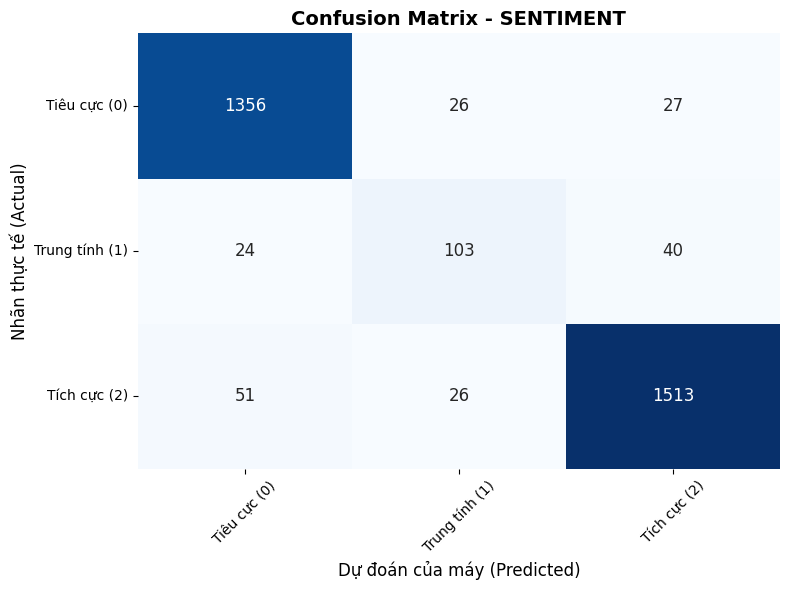

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from transformers import AutoTokenizer

def plot_confusion_matrix_custom(trainer, df_test, input_col, label_col, task_name):
    print(f"🎨 Đang vẽ ma trận nhầm lẫn cho: {task_name.upper()}...")
    
    # 1. Load Tokenizer & Tạo Dataset (Để tránh lỗi)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    test_dataset = UITVSFCDataset(
        df_test[input_col].values, 
        df_test[label_col].values, 
        tokenizer, 
        MAX_LEN
    )
    
    # 2. Lấy dự đoán từ Model
    predictions = trainer.predict(test_dataset)
    y_pred = predictions.predictions.argmax(-1)
    y_true = df_test[label_col].values
    
    # 3. Định nghĩa nhãn (Label Names)
    if task_name == 'sentiment':
        # Theo nhãn gốc của UIT-VSFC: 0=Negative, 1=Neutral, 2=Positive
        labels = ['Tiêu cực (0)', 'Trung tính (1)', 'Tích cực (2)']
    else: 
        # Topic: 0=Lecturer, 1=Curriculum, 2=Facility, 3=Others
        labels = ['Giảng viên (0)', 'Chương trình (1)', 'CSVC (2)', 'Khác (3)']

    # 4. Tính toán Ma trận
    cm = confusion_matrix(y_true, y_pred)
    
    # 5. Vẽ Heatmap bằng Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
    
    # Trang trí
    plt.title(f'Confusion Matrix - {task_name.upper()}', fontsize=14, fontweight='bold')
    plt.xlabel('Dự đoán của máy (Predicted)', fontsize=12)
    plt.ylabel('Nhãn thực tế (Actual)', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- GỌI HÀM VẼ ---

plot_confusion_matrix_custom(
    sentiment_trainer, 
    df_test, 
    "sentence_segmented", 
    "sentiment", 
    "sentiment"
)


In [25]:
from sklearn.metrics import classification_report
import pandas as pd
from transformers import AutoTokenizer

def generate_paper_comparison_table(trainer, df_test, input_col, label_col, task_name):
    print(f"\n{'='*30}")
    print(f"📊 BẢNG KẾT QUẢ CHI TIẾT: {task_name.upper()}")
    print(f"{'='*30}")
    
    # 1. Load Tokenizer & Predict
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    test_dataset = UITVSFCDataset(
        df_test[input_col].values, 
        df_test[label_col].values, 
        tokenizer, 
        MAX_LEN
    )
    
    predictions = trainer.predict(test_dataset)
    y_pred = predictions.predictions.argmax(-1)
    y_true = df_test[label_col].values
    
    # 2. Định nghĩa tên nhãn (Khớp với bài báo để dễ so sánh)
    if task_name == 'sentiment':
        # Thứ tự model output là 0, 1, 2. Ta đặt tên tương ứng
        target_names = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
        # Lưu ý: Bài báo sắp xếp là Positive -> Negative -> Neutral
    else:
        # Topic
        target_names = ['Lecturer (0)', 'Curriculum (1)', 'Facility (2)', 'Others (3)']

    # 3. Tạo báo cáo
    report_dict = classification_report(
        y_true, 
        y_pred, 
        target_names=target_names, 
        output_dict=True,
        digits=4 # Lấy 4 chữ số thập phân
    )
    
    # 4. Chuyển thành DataFrame đẹp
    df_report = pd.DataFrame(report_dict).transpose()
    
    # Lọc và đổi tên cột cho giống bài báo
    df_report = df_report[['precision', 'recall', 'f1-score']]
    df_report.columns = ['Precision', 'Recall', 'F1-score']
    
    # Nhân 100 để ra đơn vị %
    df_report = df_report * 100
    
    # Hiển thị
    print(df_report.round(2)) # Làm tròn 2 chữ số như bài báo
    return df_report

# --- CHẠY ---

df_sent_final = generate_paper_comparison_table(
    sentiment_trainer, df_test, "sentence_segmented", "sentiment", "sentiment"
)


📊 BẢNG KẾT QUẢ CHI TIẾT: SENTIMENT


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              Precision  Recall  F1-score
Negative (0)      94.76   96.24     95.49
Neutral (1)       66.45   61.68     63.98
Positive (2)      95.76   95.16     95.46
accuracy          93.87   93.87     93.87
macro avg         85.66   84.36     84.98
weighted avg      93.77   93.87     93.81


In [26]:
from transformers import AutoTokenizer
import pandas as pd
import os

def save_wrong_predictions(trainer, df_test, input_col, label_col, task_name):
    print(f"\n{'='*20} TRÍCH XUẤT LỖI: {task_name.upper()} {'='*20}")
    
    # 1. Load Tokenizer & Predict
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    test_dataset = UITVSFCDataset(
        df_test[input_col].values, 
        df_test[label_col].values, 
        tokenizer, 
        MAX_LEN
    )
    
    print(">>> Đang chạy dự đoán trên tập Test...")
    predictions = trainer.predict(test_dataset)
    y_pred = predictions.predictions.argmax(-1)
    y_true = df_test[label_col].values
    
    # 2. Định nghĩa Map nhãn
    if task_name == 'sentiment':
        label_map = {0: 'Tiêu cực', 1: 'Trung tính', 2: 'Tích cực'}
    else: # topic
        label_map = {0: 'Giảng viên', 1: 'Chương trình', 2: 'CSVC', 3: 'Khác'}

    # 3. Tìm các index bị sai
    wrong_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
    
    # 4. Thu thập dữ liệu sai vào list
    error_data = []
    
    for i in wrong_indices:
        row = df_test.iloc[i]
        
        # Lấy câu hiển thị (Ưu tiên câu gốc chưa tách từ cho dễ đọc)
        # Kiểm tra xem trong df_test có cột 'sentence_final' (đã clean) hay 'sentence' gốc không
        if 'sentence_final' in df_test.columns:
            text_display = row['sentence_final']
        elif 'sentence' in df_test.columns:
            text_display = row['sentence']
        else:
            text_display = row[input_col] # Lấy sentence_segmented nếu không có cột nào khác
            
        error_data.append({
            'Index': i,
            'Câu (Text)': text_display,
            'Nhãn Thực (ID)': row[label_col],
            'Nhãn Thực (Text)': label_map.get(row[label_col], ''),
            'Máy Đoán (ID)': y_pred[i],
            'Máy Đoán (Text)': label_map.get(y_pred[i], '')
        })
    
    # 5. Tạo DataFrame và Lưu ra CSV
    df_errors = pd.DataFrame(error_data)
    
    # Tên file
    filename = f"errors_{task_name}.csv"
    
    # Lưu file (encoding='utf-8-sig' để mở Excel không bị lỗi font tiếng Việt)
    df_errors.to_csv(filename, index=False, encoding='utf-8-sig')
    
    print(f"❌ Tổng số câu sai: {len(df_errors)} / {len(df_test)}")
    print(f"✅ Đã lưu file chi tiết tại: {filename}")
    
    # Hiển thị 5 dòng đầu xem thử
    print("\n--- Xem trước 5 lỗi đầu tiên ---")
    print(df_errors[['Câu (Text)', 'Nhãn Thực (Text)', 'Máy Đoán (Text)']].head(5))
    
    return df_errors

# --- CHẠY VÀ LƯU FILE ---

df_err_sent = save_wrong_predictions(
    sentiment_trainer, 
    df_test, 
    "sentence_segmented", 
    "sentiment", 
    "sentiment"
)



==================== TRÍCH XUẤT LỖI: SENTIMENT ====================
>>> Đang chạy dự đoán trên tập Test...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


❌ Tổng số câu sai: 194 / 3166
✅ Đã lưu file chi tiết tại: errors_sentiment.csv

--- Xem trước 5 lỗi đầu tiên ---
                                          Câu (Text) Nhãn Thực (Text)  \
0                       tính điểm thi đua các nhóm .         Tích cực   
1  trong trường macbook thầy số hai thì không có ...         Tích cực   
2  môn học này giúp chúng em hiểu ra những vấn đề...       Trung tính   
3             phần lớn chỉ là lý thuyết và bài tập .         Tích cực   
4  như vậy tụi em sẽ định hướng tốt hơn và tập tr...       Trung tính   

  Máy Đoán (Text)  
0      Trung tính  
1        Tiêu cực  
2        Tích cực  
3        Tiêu cực  
4        Tích cực  
